# Feature Engineering

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import re
import string
import warnings
warnings.filterwarnings('ignore')

In [2]:
transactions_by_customer = pd.read_csv('transactions_by_customer_DW.csv')

### Label encode age_range, family_size, income_bracket

In [3]:
transactions_by_customer['age_range'] = transactions_by_customer['age_range'].astype(str)
le = preprocessing.LabelEncoder()
transactions_by_customer['age_range'] = le.fit_transform(transactions_by_customer['age_range'].values)
transactions_by_customer['family_size'] = transactions_by_customer['family_size'].astype(str)
transactions_by_customer['family_size'] = le.fit_transform(transactions_by_customer['family_size'].values)
transactions_by_customer['income_bracket'] = transactions_by_customer['income_bracket'].astype(str)
transactions_by_customer['income_bracket'] = le.fit_transform(transactions_by_customer['income_bracket'].values)

### One-hot encode day, month, year, weekday, brand_type, rented

In [4]:
weekday_ohe = pd.get_dummies(transactions_by_customer['weekday'])
month_ohe = pd.get_dummies(transactions_by_customer['month'])
day_ohe = pd.get_dummies(transactions_by_customer['day'])
year_ohe = pd.get_dummies(transactions_by_customer['year'])

transactions_by_customer = pd.concat([transactions_by_customer, day_ohe, month_ohe, year_ohe, weekday_ohe], axis=1) #ddding one-hot encoded columns
transactions_by_customer.drop(['date', 'weekday', 'month', 'year', 'day'], axis=1, inplace=True) #dropping original columns

transactions_by_customer['brand_type'] = pd.get_dummies(transactions_by_customer['brand_type'])
transactions_by_customer['rented'] = pd.get_dummies(transactions_by_customer['rented'])

### One-hot encode category

In [5]:
transactions_by_customer['category'].value_counts()

Grocery                   558555
Pharmaceutical             93734
Packaged Meat              37105
Natural Products           33469
Dairy, Juices & Snacks     13428
Meat                       13221
Bakery                     11437
Fuel                        8637
Prepared Food               8011
Seafood                     4104
Skin & Hair Care            3014
Miscellaneous               1985
Flowers & Plants             997
Alcohol                      694
Garden                       294
Salads                       217
Travel                       131
Restauarant                  129
Vegetables (cut)              65
Name: category, dtype: int64

In [6]:
transactions_by_customer['category'] = transactions_by_customer['category'].str.strip()

map_category = {'Vegetables (cut)':'Grocery', 'Skin & Hair Care': 'Pharmaceutical', 'Packaged Meat':'Meat', 'Seafood':'Meat', \
                'Bakery':'Fresh Food', 'Prepared Food':'Fresh Food', 'Restaurant':'Fresh Food', 'Alcohol':'Miscellaneous', \
                'Fuel':'Miscellaneous', 'Flowers & Plants':'Miscellaneous', 'Garden': 'Miscellaneous', 'Travel':'Miscellaneous', \
                'Grocery':'Grocery', 'Pharmaceutical':'Pharmaceutical', 'Natural Products': 'Natural Products', 'Meat':'Meat', \
                'Dairy, Juices & Snacks':'Dairy & Snacks', 'Miscellaneous':'Miscellaneous', 'Salads':'Grocery'}
transactions_by_customer['category'] = transactions_by_customer['category'].map(map_category)
transactions_by_customer['category'].value_counts()

Grocery             558837
Pharmaceutical       96748
Meat                 54430
Natural Products     33469
Fresh Food           19448
Dairy & Snacks       13428
Miscellaneous        12738
Name: category, dtype: int64

In [7]:
category_ohe = pd.get_dummies(transactions_by_customer['category'])
transactions_by_customer = pd.concat([transactions_by_customer, category_ohe], axis=1) #ddding one-hot encoded columns
transactions_by_customer.drop(['category'], axis=1, inplace=True) #dropping original column
transactions_by_customer.head()

,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,age_range,marital_status,rented,family_size,...,Thursday,Tuesday,Wednesday,Dairy & Snacks,Fresh Food,Grocery,Meat,Miscellaneous,Natural Products,Pharmaceutical
0,1,4315,1,201.97,0.0,0.0,5,Married,1,1,...,1,0,0,0,0,0,0,0,0,1
1,1,4577,2,120.40,0.0,0.0,5,Married,1,1,...,0,0,1,0,0,1,0,0,0,0
2,1,4796,1,106.50,0.0,0.0,5,Married,1,1,...,1,0,0,0,0,1,0,0,0,0
3,1,4953,1,142.12,0.0,0.0,5,Married,1,1,...,0,1,0,0,0,1,0,0,0,0
4,1,4953,1,142.12,0.0,0.0,5,Married,1,1,...,1,0,0,0,0,1,0,0,0,0


In [8]:
transactions_by_customer.head()

,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,age_range,marital_status,rented,family_size,...,Thursday,Tuesday,Wednesday,Dairy & Snacks,Fresh Food,Grocery,Meat,Miscellaneous,Natural Products,Pharmaceutical
0,1,4315,1,201.97,0.0,0.0,5,Married,1,1,...,1,0,0,0,0,0,0,0,0,1
1,1,4577,2,120.40,0.0,0.0,5,Married,1,1,...,0,0,1,0,0,1,0,0,0,0
2,1,4796,1,106.50,0.0,0.0,5,Married,1,1,...,1,0,0,0,0,1,0,0,0,0
3,1,4953,1,142.12,0.0,0.0,5,Married,1,1,...,0,1,0,0,0,1,0,0,0,0
4,1,4953,1,142.12,0.0,0.0,5,Married,1,1,...,1,0,0,0,0,1,0,0,0,0


In [9]:
transactions_by_customer.columns

Index([     'customer_id',          'item_id',         'quantity',
          'selling_price',   'other_discount',  'coupon_discount',
              'age_range',   'marital_status',           'rented',
            'family_size',   'no_of_children',   'income_bracket',
                  'brand',       'brand_type',             'week',
                        1,                  2,                  3,
                        4,                  5,                  6,
                        7,                  8,                  9,
                       10,                 11,                 12,
                       13,                 14,                 15,
                       16,                 17,                 18,
                       19,                 20,                 21,
                       22,                 23,                 24,
                       25,                 26,                 27,
                       28,                 29,                

In [10]:
transactions_by_customer.columns = transactions_by_customer.columns.map(str)
transactions_by_customer.columns

Index(['customer_id', 'item_id', 'quantity', 'selling_price', 'other_discount',
       'coupon_discount', 'age_range', 'marital_status', 'rented',
       'family_size', 'no_of_children', 'income_bracket', 'brand',
       'brand_type', 'week', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', 'April', 'August',
       'December', 'February', 'January', 'July', 'June', 'March', 'May',
       'November', 'October', 'September', '2012', '2013', 'Friday', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'Dairy & Snacks', 'Fresh Food', 'Grocery', 'Meat', 'Miscellaneous',
       'Natural Products', 'Pharmaceutical'],
      dtype='object')

In [11]:
transactions_by_customer.shape

(789227, 74)

### Drop redundant columns and columns with significant number of null values

In [12]:
transactions_by_customer.drop(['no_of_children', 'marital_status', 'brand', 'quantity', 'customer_id', 'item_id'], axis=1, inplace=True)

### Add Dependent Variable

In [13]:
transactions_by_customer['redemption_status'] = 0
transactions_by_customer['redemption_status'][transactions_by_customer['coupon_discount']!=0] = 1

# Modeling

In [14]:
X = transactions_by_customer.drop(['redemption_status'], axis=1) #Predictor Variables
y = transactions_by_customer['redemption_status'] #Target variable

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [16]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [17]:
final_iv, IV = data_vars(X_train, y_train)

In [18]:
features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
X2 = X_train[features]
X2.head()

,Fresh Food,Grocery,Meat,Miscellaneous,Natural Products,Pharmaceutical,brand_type,family_size,income_bracket,other_discount,selling_price
468346,0,1,0,0,0,0,1,1,6,-113.98,113.27
736973,0,1,0,0,0,0,1,2,0,-3.56,35.26
138196,1,0,0,0,0,0,0,0,9,0.00,53.07
648960,0,1,0,0,0,0,1,4,8,0.00,106.50
510918,0,1,0,0,0,0,1,1,4,0.00,70.88


In [19]:
def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns
        
        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')

X1 = X2._get_numeric_data()
final_df, final_vif = iterate_vif(X1)

Iteration # 1
Removing Grocery with VIF of 6.174583
Iteration # 2
Complete


In [20]:
X_train=final_df
X_train.head()

,Fresh Food,Meat,Miscellaneous,Natural Products,Pharmaceutical,brand_type,family_size,income_bracket,other_discount,selling_price
468346,0,0,0,0,0,1,1,6,-113.98,113.27
736973,0,0,0,0,0,1,2,0,-3.56,35.26
138196,1,0,0,0,0,0,0,9,0.00,53.07
648960,0,0,0,0,0,1,4,8,0.00,106.50
510918,0,0,0,0,0,1,1,4,0.00,70.88


In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve




def run_regression_accuracy(X_train, y_train, X_test, y_test):
  logreg = LogisticRegression()
  logreg.fit(X_train, y_train)
  y_pred = logreg.predict(X_test)
  print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
  cm = confusion_matrix(y_test, y_pred)
  print('\nConfusion matrix: \n',cm)

  print('\nClassification report: \n',classification_report(y_test, y_pred))

  logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
  fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

  plt.figure()
  plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()
  
  return logreg

In [22]:
X_test=X_test[X_train.columns]
X_test.head()

,Fresh Food,Meat,Miscellaneous,Natural Products,Pharmaceutical,brand_type,family_size,income_bracket,other_discount,selling_price
739466,0,0,0,0,0,1,0,7,0.00,57.70
672915,0,0,0,0,0,1,1,7,0.00,95.82
181442,0,0,0,0,1,0,2,6,0.00,117.19
158044,0,0,0,0,0,1,1,7,-24.58,53.43
552425,0,0,0,0,0,0,1,11,0.00,14.25


Accuracy of logistic regression classifier on test set: 0.98

Confusion matrix: 
 [[193575     30]
 [  3697      5]]

Classification report: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    193605
           1       0.14      0.00      0.00      3702

    accuracy                           0.98    197307
   macro avg       0.56      0.50      0.50    197307
weighted avg       0.97      0.98      0.97    197307



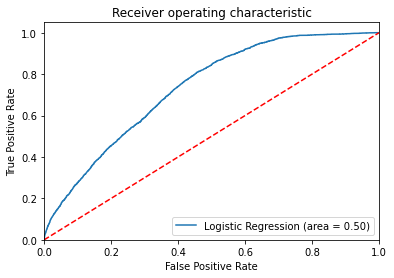

In [23]:
logreg = run_regression_accuracy(X_train, y_train, X_test, y_test)

In [24]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 10, random_state = 42, max_depth=50, class_weight=dict({1:48, 0:1}), verbose=2)
# Train the model on training data
rf.fit(X_train, y_train)

y_pred1 = rf.predict(X_test)

roc1 = roc_auc_score(y_test, y_pred1)

roc1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


0.6098781638515521

In [25]:
conf1 = confusion_matrix(y_test, y_pred1)
conf1

array([[182180,  11425],
       [  2670,   1032]], dtype=int64)

In [26]:
# Import the model we are using
from sklearn.linear_model import LogisticRegression

# Instantiate model
lr = LogisticRegression(C=1, tol=0.1, multi_class='ovr', class_weight=dict({1:49, 0:1}), solver='newton-cg', max_iter=10, n_jobs=-1, verbose=2)
# Train the model on training data
lr.fit(X_train, y_train)

y_pred2 = lr.predict(X_test)

roc2 = roc_auc_score(y_test, y_pred2)

roc2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s finished


0.6523664471307999

In [27]:
conf2 = confusion_matrix(y_test, y_pred2.round())
conf2

array([[ 71340, 122265],
       [   236,   3466]], dtype=int64)

In [28]:
# Import the model we are using
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Instantiate model with 100 decision trees
xgb = XGBClassifier(n_estimators = 10, max_depth=30, max_delta_step=4, scale_pos_weight=49, random_state = 42, verbosity=2, n_jobs=-1)
# Train the model on training data
xgb.fit(X_train, y_train)

y_pred3 = xgb.predict(X_test)

roc3 = roc_auc_score(y_test, y_pred3)

roc3

[12:15:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 19744 extra nodes, 0 pruned nodes, max_depth=30
[12:15:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:15:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 19596 extra nodes, 0 pruned nodes, max_depth=30
[12:15:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 20454 extra nodes, 0 pruned nodes, max_depth=30
[12:15:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 19930 extra nodes, 0 pruned nodes, max

0.7113896458381547

In [29]:
conf2 = confusion_matrix(y_test, y_pred2.round())
conf2

array([[ 71340, 122265],
       [   236,   3466]], dtype=int64)

# Hyperparameter Testing

In [30]:
def algorithm_pipeline(X_train, X_test, y_train, y_test, \
                       model, param_grid, cv=10, scoring_fit='ne_mean_squared_error', do_probabilities=False):
    gs = GridSearchCV(estimator=model, \
                      param_grid=param_grid, \
                      cv=cv, \
                      n_jobs=-1, \
                      scoring=scoring_fit, \
                      verbose=2)
    
    fitted_model = gs.fit(X_train, y_train)
    
    if do_probabilities:
        pred = fitted_model.predict_proba(X_test)
    else:
        pred = fitted_model.predict(X_test)
    return fitted_model, pred

In [31]:
param_grid = {'eta': [0.01, 0.05, 0.1], \
              'max_depth': [9, 10, 11], \
              'scale_pos_weight': [49, 50, 51], \
              'max_delta_step': [4, 6, 8], \
              'grow_policy':['depthwise', 'losswise']}

model = XGBClassifier( n_jobs=32, random_state = 42, verbosity=2)

In [32]:
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, param_grid, cv=10, scoring_fit='roc_auc')

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 41.4min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 55.5min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 82.6min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 121.7min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 124.1min finished


[14:19:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 756 extra nodes, 0 pruned nodes, max_depth=10
[14:19:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:19:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 816 extra nodes, 0 pruned nodes, max_depth=10
[14:19:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 844 extra nodes, 0 pruned nodes, max_depth=10
[14:19:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 894 extra nodes, 0 pruned nodes, max_depth=1

[14:20:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=10
[14:20:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 582 extra nodes, 0 pruned nodes, max_depth=10
[14:20:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 406 extra nodes, 0 pruned nodes, max_depth=10
[14:20:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 558 extra nodes, 0 pruned nodes, max_depth=10
[14:20:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 466 extra nodes, 0 pruned nodes, max_depth=10
[14:20:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 444 extr

[14:20:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 552 extra nodes, 0 pruned nodes, max_depth=10
[14:20:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 908 extra nodes, 0 pruned nodes, max_depth=10
[14:20:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 620 extra nodes, 0 pruned nodes, max_depth=10
[14:20:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 602 extra nodes, 0 pruned nodes, max_depth=10
[14:20:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 296 extra nodes, 0 pruned nodes, max_depth=10
[14:20:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 220 extr

In [33]:
print(model.best_score_)
print(model.best_params_)

0.862946635495139
{'eta': 0.1, 'grow_policy': 'depthwise', 'max_delta_step': 4, 'max_depth': 10, 'scale_pos_weight': 51}


In [34]:
xgb = XGBClassifier(eta=0.1, max_depth=11, scale_pos_weight=49, max_delta_step=8, grow_policy='depthwise', n_jobs=-1, random_state = 42, verbosity=2)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

roc = roc_auc_score(y_test, y_pred)

roc

[14:20:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 1146 extra nodes, 0 pruned nodes, max_depth=11
[14:20:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 1278 extra nodes, 0 pruned nodes, max_depth=11
[14:20:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 1172 extra nodes, 0 pruned nodes, max_depth=11
[14:20:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 1260 extra nodes, 0 pruned nodes, max_dep

[14:20:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 562 extra nodes, 0 pruned nodes, max_depth=11
[14:20:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 544 extra nodes, 0 pruned nodes, max_depth=11
[14:20:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 514 extra nodes, 0 pruned nodes, max_depth=11
[14:20:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 826 extra nodes, 0 pruned nodes, max_depth=11
[14:20:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 526 extra nodes, 0 pruned nodes, max_depth=11
[14:20:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 776 extr

[14:20:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 1062 extra nodes, 0 pruned nodes, max_depth=11
[14:20:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 582 extra nodes, 0 pruned nodes, max_depth=11
[14:20:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 704 extra nodes, 0 pruned nodes, max_depth=11
[14:20:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 962 extra nodes, 0 pruned nodes, max_depth=11
[14:20:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 880 extra nodes, 0 pruned nodes, max_depth=11
[14:20:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 718 ext

0.7682951808719126

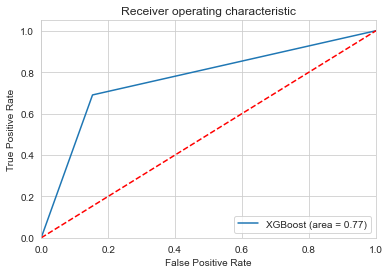

In [35]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)

sns.set_style('whitegrid')
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('XGB_ROC')
plt.show()

In [36]:
conf = confusion_matrix(y_test, y_pred.round())
conf

array([[163924,  29681],
       [  1148,   2554]], dtype=int64)

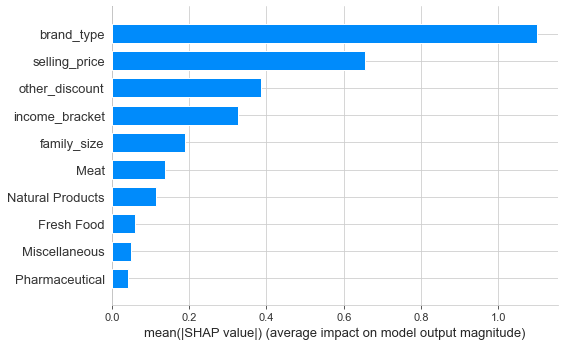

In [37]:
shap_values = shap.TreeExplainer(xgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

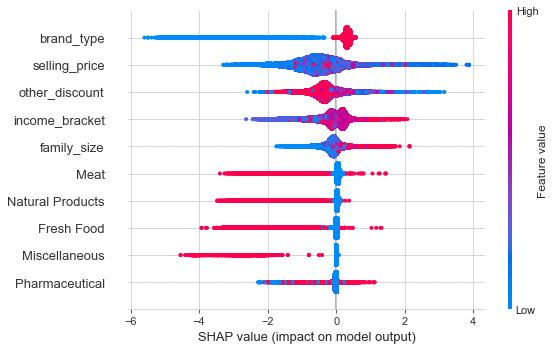

In [38]:
shap.summary_plot(shap_values, X_train)

The two graphs above show us that the most important features that contribute to prediction of coupon redemption are:
1. **Brand Type (Established vs. New)** The summary plot shows that people are more inclined to redeem a coupon if an established brand offers it. This is expected as customers tend to place more trust in bigger, long running brands.
2. **Selling Price** This is the second most important feature. Acoording to the summary plot, there is no clear linear relationship etween the selling price of an item and the coupon redemption rate. This can also be seen in the histplot between these columns in the EDA notebook. Most coupons are redeemed between selling price of 50 and 100. Coupon redemption falls off for higher priced items. This could be because fewer coupons are offered for high priced items.
3. **Other Discount** The higher the value of other discount, the lower the coupon redemption. This makes sense as brands tend to not offer double discounts on the selling rpice.
4. **Income Bracket** There is no linear relationship between income bracket and coupon redemption. As can be seen from the bar plot in the EDA notebook, highest coupon redemption takes place in mid-range income brackets. This could be because the lower income households do not have enough resources to look for coupons and the higher income housholds don't care about spending some extra dollars.
5. **Family Size** As the family size increase, coupon redemption increases. This makes sense since families with higher number of members still have 1 or 2 earning heads and would look for every opportunity to save money.
6. **Meat** People tend to redeem more coupons on meat since meat itms are high priced.
7. **Natural Products** The same is true for natural products. They tend to be higher proiced so people are prone to redeeming coupons on these.
8. **Fresh Food** Again, these are higher priced so more coupons get redeemed on them.
9. **Miscellaneous** Again, these are higher priced so more coupons get redeemed on them.
10. **Pharmaceutical** Again, these are higher priced so more coupons get redeemed on them.